# End-to-end multi class dog breed classification

This notebook builds an end to end multi-class image classifier using Tenserflow.

## 1. Problem
Identify the breed of dog, given the image.

## 2. Data
The data we're using is from Kaggle's Dog Breed Identification Problem: https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
Multi Class Log Loss between the predicted probability and the observed target.

## 4. Features
* We're dealing with images ( unstructured data ), so we will be using deep learning.
* There are 120 different classes.
* There are 10,000+ images in train set and test set ( each ).

In [1]:
# unzip the data folder
# !unzip dog-breed-identification.zip

# Get our workspace ready

In [2]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

print("Using tensorflow version: ", tf.__version__)
print("Using tensorflow hub version: ", hub.__version__)

print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

Using tensorflow version:  2.19.0
Using tensorflow hub version:  0.16.1
GPU available


## Getting our data ready ( Turning into sensors)

For all machine learning models, we have to turn our data into numerical representation. For this, we will be turning our data into tensors.

In [3]:
# load labels
labels_df = pd.read_csv("drive/MyDrive/dog-breed-identification/labels.csv")
labels_df.tail()
# labels_df.info()

,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


<Axes: xlabel='breed'>

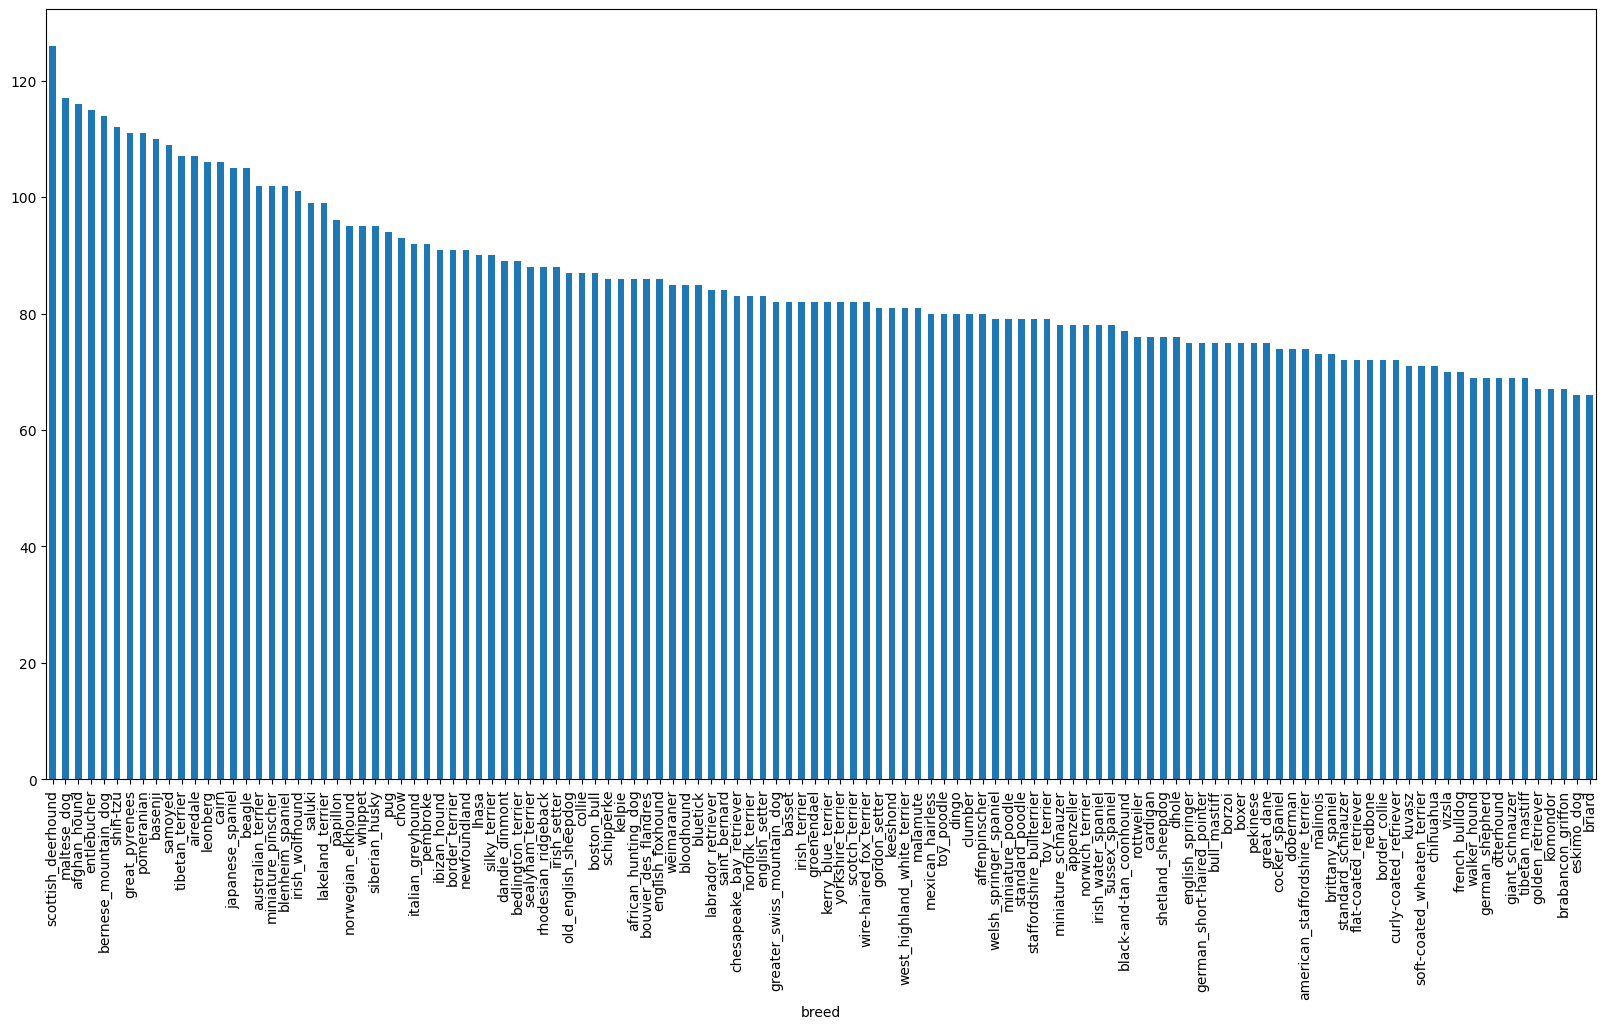

In [4]:
# check for dog classes
# labels_df["breed"].value_counts()
labels_df["breed"].value_counts().plot.bar(figsize=(20,10))

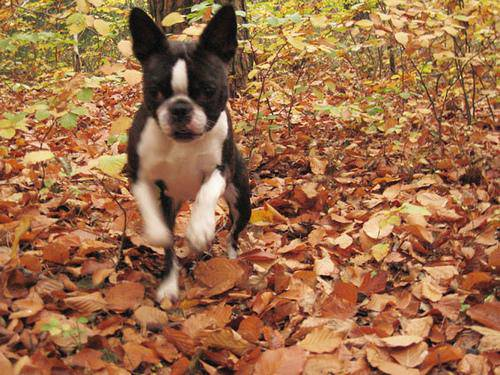

In [5]:
# view an image
from IPython.display import Image
Image("drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

## Let's get the list of all image-pathnames.

In [6]:
# create pathnames from image id's

filenames = ["drive/MyDrive/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_df["id"]]
len(filenames)

10222

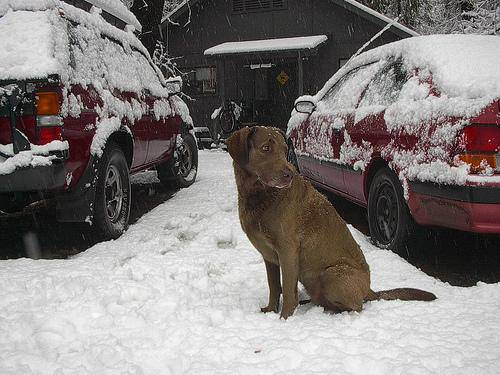

In [7]:
# check if the number of filenames matches the actual files
import os

# if len(os.listdir("drive/MyDrive/dog-breed-identification/train/")) == len(filenames):
#   print('tada')
# else:
#   print('no no')

Image(filenames[10221])


In [8]:
labels_df['breed'][10221]

'chesapeake_bay_retriever'

In [9]:
import numpy as np

labels = labels_df["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [10]:
# check if number of labels matches number of filenames

if len(labels) == len(filenames):
  print("the numbers match")
else:
  print("the numbers don't match up")

the numbers match


In [11]:
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [12]:
# turn a label into boolean array

# labels[0] = labels[0] == unique_breeds
# labels[0]

In [13]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]
len(boolean_labels)

10222

## Creating our validation set

In [14]:
# set up X and y variables
X = filenames
y = boolean_labels
len(X), len(y)

(10222, 10222)

We're going to start experimenting with ~1000 images and then increase as we go.

In [45]:
NUM_IMAGES = 10000

# let's split our data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(8000, 8000, 2000, 2000)

In [16]:
X_train[:1], y_train[:1]

(['drive/MyDrive/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, Fals

## Preprocessing images ( turning images into tensors )

We're going to write a function to convert image into tensors.

1. Take an image filepath as an input
2. Use tensorflow to read the file and save it into variable `image`
3. Turn the image to tensors
4. Resize the image to fixed shape (224, 224)
5. Return processed image

In [43]:
import tensorflow as tf

def load_image_to_tensor(file_path, image_size=(224, 224), normalize=True):
    image = tf.io.read_file(file_path)

    # Use a specific decoder
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, image_size)

    if normalize:
        image = tf.image.convert_image_dtype(image, tf.float32)

    return image

## Turning our data into batches

In order to use tensorflow effectively, we need our data in the form of tensor tuples which looks like this `(image, label)`.
`32` is the standard batch size.

In [44]:
# create a function to return a tuple (image, label)

def image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = load_image_to_tensor(image_path)
  return (image, label)

In [46]:
# Define batch size
BATCH_SIZE = 32

# create function to return batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """

  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(map_func=load_image_to_tensor).batch(BATCH_SIZE)
    return data_batch

  if valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(map_func=image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(map_func=image_label).batch(BATCH_SIZE)
    return data_batch

In [47]:
# create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

train_data.element_spec
# num_batches = len(list(train_data))
# print(num_batches)

Creating training data batches...
Creating validation data batches...


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

In [48]:
# visualize data batches

import matplotlib.pyplot as plt

def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax=plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

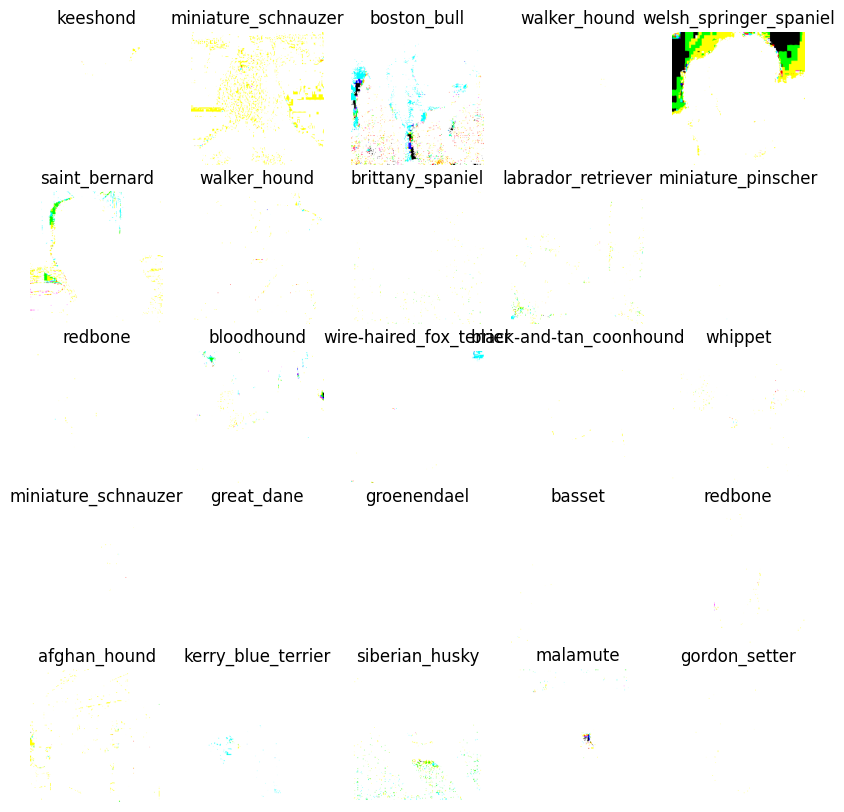

In [22]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [49]:
len(train_images), len(train_labels)

(32, 32)

## Building our model

Before we build our model, there's a few things we need to define:
1. The input shape ( our images shape, in the form of tensors ) to the model.
2. The output shape ( our labels, in the form of tensors ) of our model.
3. The url of the model, we want to use from tensorflow hub.

In [50]:
# set up input shape
INPUT_SHAPE = (224, 224, 3) # height, width, color channels

# set up output shape
OUTPUT_SHAPE = len(unique_breeds)

# set up model url from tensorflow hub
MODEL_URL = MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4"

## Now, we've got our inputs and outputs. Let's start with `Kera's` deep learning model.

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Number of classes (matches label shape: (None, 120))
NUM_CLASSES = 120

# Image size (matches input tensor: (224, 224, 3))
IMG_SIZE = (224, 224)

In [52]:
def create_model():
    """
    Image classification model using EfficientNetB0.
    Input  : (None, 224, 224, 3)
    Output : (None, 120) → one-hot encoded labels
    """

    # Load pretrained EfficientNet (feature extractor)
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,           # Remove ImageNet classifier
        weights="imagenet",          # Pretrained weights
        input_shape=IMG_SIZE + (3,)
    )

    # Freeze pretrained layers for initial training
    base_model.trainable = False

    # Define model input
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

    # Pass images through EfficientNet
    # training=False ensures BatchNorm behaves correctly
    x = base_model(inputs, training=False)

    # Reduce spatial dimensions (H, W) → single feature vector
    x = layers.GlobalAveragePooling2D()(x)

    # Normalize activations to stabilize learning
    x = layers.BatchNormalization()(x)

    # Fully connected layer for learning dataset-specific features
    x = layers.Dense(512, activation="relu")(x)

    # Dropout to reduce overfitting
    x = layers.Dropout(0.5)(x)

    # Output layer: one neuron per class
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    # Build the model
    model = models.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",  # For one-hot labels
        metrics=["accuracy"]
    )

    return model

In [53]:
# Create model instance
model = create_model()

# Print architecture, shapes, and parameter counts
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,772,123 (18.20 MB)

 Trainable params: 719,992 (2.75 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

## Train the model

In [37]:
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 209s 7s/step - accuracy: 0.0598 - loss: 5.2626 - val_accuracy: 0.4300 - val_loss: 3.5778
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.6377 - loss: 1.4451 - val_accuracy: 0.5950 - val_loss: 2.7278
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.8362 - loss: 0.5593 - val_accuracy: 0.6250 - val_loss: 2.1859
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.8980 - loss: 0.3663 - val_accuracy: 0.6450 - val_loss: 1.8983
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.9378 - loss: 0.2318 - val_accuracy: 0.6450 - val_loss: 1.6407
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9662 - loss: 0.1404 - val_accuracy: 0.6750 - val_loss: 1.4418
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9763 - loss: 0.1184 - val_accuracy: 0.7050 - val_loss: 1.3231
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9837 - loss: 0.0762 - val_accuracy: 0.7

In [54]:
# Unfreeze the pretrained base
base_model = model.layers[1]  # EfficientNetB0
base_model.trainable = True   # make all layers trainable

# Optional: freeze early layers for small dataset
for layer in base_model.layers[:-20]:  # only fine-tune last 20 layers
    layer.trainable = False

# Recompile with a very low learning rate
# Always recompile AFTER changing trainable status
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [56]:
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1607s 6s/step - accuracy: 0.0103 - loss: 5.7656 - val_accuracy: 0.0375 - val_loss: 4.6532
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 235ms/step - accuracy: 0.0272 - loss: 5.2262 - val_accuracy: 0.0910 - val_loss: 4.2979
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 212ms/step - accuracy: 0.0536 - loss: 4.7302 - val_accuracy: 0.1830 - val_loss: 3.8275
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.0919 - loss: 4.3217 - val_accuracy: 0.2790 - val_loss: 3.3778
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 238ms/step - accuracy: 0.1415 - loss: 3.9109 - val_accuracy: 0.3860 - val_loss: 2.9768
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - accuracy: 0.2035 - loss: 3.5108 - val_accuracy: 0.4405 - val_loss: 2.6230
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.2573 - loss: 3.1840 - val_accuracy: 0.5005 - val_loss: 2.3245
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 224ms/step - accuracy: 0.3163 - loss: 2.

In [57]:
# Evaluate model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_data)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.6043 - loss: 1.6948
Validation Loss: 1.6880
Validation Accuracy: 0.6095


## Make Predictions

In [58]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Image size expected by the model
IMG_SIZE = (224, 224)

# Path to your test images folder
test_folder = "drive/MyDrive/dog-breed-identification/test"

# Unique breeds array (from your dataset)
# Example: unique_breeds = np.array(['beagle', 'poodle', 'golden_retriever', ...])
class_names = unique_breeds.tolist()  # convert to Python list for indexing

In [70]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_preprocess(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Use EfficientNet preprocessing
    img_array = preprocess_input(img_array)  # scales pixels to [-1, 1]

    return img_array

In [76]:
predictions = []
image_files = os.listdir(test_folder)[:20]  # ensure consistent order

for img_file in image_files:
    img_path = os.path.join(test_folder, img_file)
    img_tensor = load_and_preprocess(img_path)

    # Get prediction probabilities
    probs = model.predict(img_tensor)

    # Index of the class with highest probability
    pred_class = np.argmax(probs, axis=1)[0]

    # Map index to actual dog breed
    pred_label = class_names[pred_class]

    # Save result
    predictions.append((img_file, pred_label))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [77]:
predictions_df = pd.DataFrame(predictions, columns=['id', 'breed'])
predictions_df.head(10)

,id,breed
0,e7b4b0e7d7d76f8dbd64920f34443b25.jpg,weimaraner
1,e85d4e2707683df0e6387e19b67b873d.jpg,border_terrier
2,e7f95aabf775a636b3893ffa120adaf9.jpg,affenpinscher
3,e7feb64da6aae1ef8e62453f6660d0c5.jpg,chow
4,e76a58909e6e1196bdefb3105060bcbe.jpg,norwegian_elkhound
5,e7e9624f2a2e61ab187358f5968bfde8.jpg,saint_bernard
6,e7a1b7a42db97df750aeae212a02d9c4.jpg,old_english_sheepdog
7,e76a7a1d23d687b5015b07df762c0c10.jpg,pembroke
8,e800b6c8d2904e205d67ada800907762.jpg,basenji
9,e826c0ae5dd27876781c10e1be444fd5.jpg,mexican_hairless


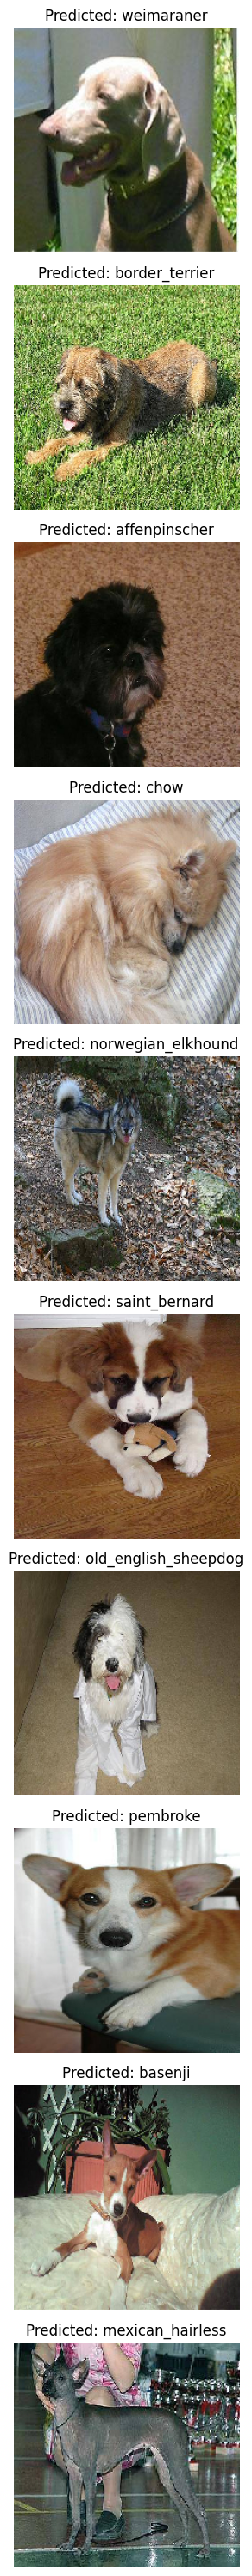

In [78]:
def show_predictions(predictions, folder_path, num_images=10):
    plt.figure(figsize=(15, num_images * 3))

    for i, (img_file, pred_label) in enumerate(predictions[:num_images]):
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=(224, 224))

        plt.subplot(num_images, 1, i+1)  # one image per row
        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show first 10 images and their predicted breeds
show_predictions(predictions, test_folder, num_images=10)